<a href="https://colab.research.google.com/github/swoo-nam/project_final_team1/blob/main/%EC%A0%95%EC%88%98%EC%9D%B8_%EC%84%9C%EB%B9%84%EC%8A%A42%EC%9E%91%EC%97%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/data/"
SEED = 42

In [10]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [4]:
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
torch.cuda.is_available()

True

In [6]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.3 MB/s eta 0:00:00


In [7]:
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 34.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.16.0-py3-none-any.whl size=30813255 sha256=df90544365a8a4fddd1efdfb1281690b02e0e66e63cece7d71c1d54eba6a78b5
  Stored in directory: /root/.cache/pip/wheels/6b/03/2b/ac2c97cc65ebd9df3516f4b900adc2f0a744df8d1375b2e2ef
Successfully built kiwipiepy-model


데이터 정제 및 전처리

In [8]:
rawyogiyo_df = pd.read_csv(f"{DATA_PATH}yogiyo_reviews_0905.csv")
yogiyo_df = rawyogiyo_df.copy()
yogiyo_df

,가게이름,고객리뷰,별점,맛별점,양별점,배달별점,사장댓글,메뉴
0,1988응답하라추억의옛날도시락-방이점,저도 모르게 은근 여기 자주 시켜먹고 있었네요ㅎ \n늘 잘먹고 있습니다,5,5,5,5.0,저희 메뉴 맛있죠?ㅎㅎ 이렇게 빠져 드시는 거에요>.<\n\n그냥 일로서 만드는 게...,제육옛날도시락＋김찌 정식＋（서비스）콜라
1,1988응답하라추억의옛날도시락-방이점,김치찌개 된장찌개 잡채\n다 잘먹었습니다,5,5,5,5.0,전부 잘 드셔 주셔서 감사합니다 ><\n\n좋은 시간을 드리고 싶었어요ㅠㅠ 열심히 ...,"돼지고기김치찌개＋대접밥,우삼겹된장찌개＋대접밥,오색빛깔 잡채"
2,1988응답하라추억의옛날도시락-방이점,처음시켜보는데 맛있고 리뷰서비스도 괜찮네요. 다음에도 또시킬듯요,5,5,5,5.0,안녕하세요~~! :D\n\n저희 매장을 처음 찾아주신 고객님이시네요😆 처음 방문이라...,"[불맛]제육 옛날도시락,우삼겹옛날도시락＋미니냉면＋（서비스）콜라"
3,1988응답하라추억의옛날도시락-방이점,맛있습니다! 근데 국물이 안와서 아쉽습니다..,4,4,4,3.0,안녕하세요 1988응답하라추억의옛날도시락입니다.\n\n저희 측 실수로 인하여 누락이...,양념갈비 옛날도시락
4,1988응답하라추억의옛날도시락-방이점,맛있게잘먹었습니다,5,5,5,5.0,"헤헤, gh**님! 감사해요! 😊 \n\n맛있게 드셨다니 앞으로도 더 열심히 일할게...","삼겹정찬도시락,돼지고기김치찌개＋대접밥"
...,...,...,...,...,...,...,...,...
24993,놀부 부대찌개-광주우산점,먹을만하다고느낍니다,4,3,3,3.0,놀부를 이용해 주셔서 감사합니다 ^^\n큰 만족을 드리지 못한것 같아 죄송합니다.\...,NaN
24994,놀부 부대찌개-광주우산점,조리를해야하는 불편함이 있긴했지만..매장에서 먹는맛 그대로이고 양도 엄청많네요 4인...,5,5,5,5.0,저희 놀부를 이용해 주셔서감사드립니다 ^^\n집에서 조리시에도 매장과 최대한 비슷하...,NaN
24995,놀부 부대찌개-광주우산점,오랜만에 놀부부대찌게~~~\n맛있었는더ㆍ\n햄 양을 늘리심 좋을듯,5,5,4,5.0,놀부를 이용해 주셔서 감사합니다 ^^\n맛있게 드셨다니 다행입니다.\n저희는 정해진...,NaN
24996,놀부 부대찌개-광주우산점,예전에 참전한 6.25 에서 먹은 부대찌개 맛이 나네요 맛있읍니다.,5,5,5,5.0,저희 놀부부대찌개를 맛있게 드셔주셔서 감사합니다 ^^\n어디서 드시더라도 항상 맛있...,NaN


In [18]:
rate_counts = yogiyo_df["별점"].value_counts().sort_index(ascending=False)
rate_counts

5    23802
4      771
3      227
2       87
1      111
Name: 별점, dtype: int64

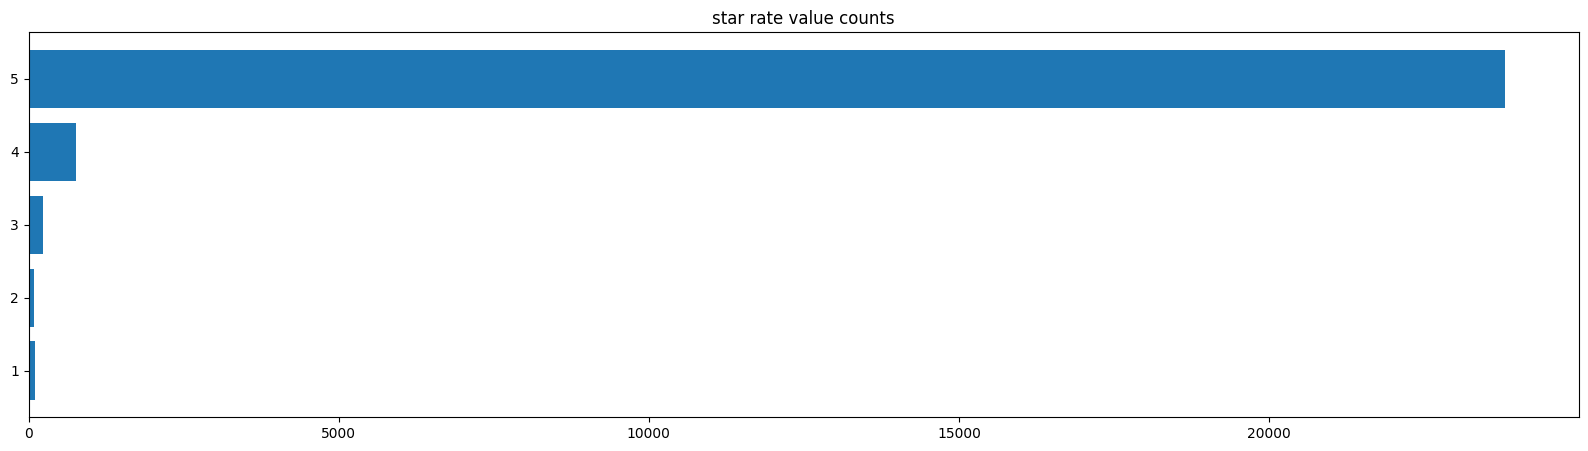

In [36]:
plt.figure(figsize=(20, 5))
plt.barh([5,4,3,2,1], rate_counts)
plt.title("star rate value counts")
plt.show()

In [28]:
delivery_rate_counts = yogiyo_df["배달별점"].value_counts().sort_index(ascending=False)
delivery_rate_counts

5.0    22593
4.0      691
3.0      250
2.0       87
1.0      185
0.0     1192
Name: 배달별점, dtype: int64

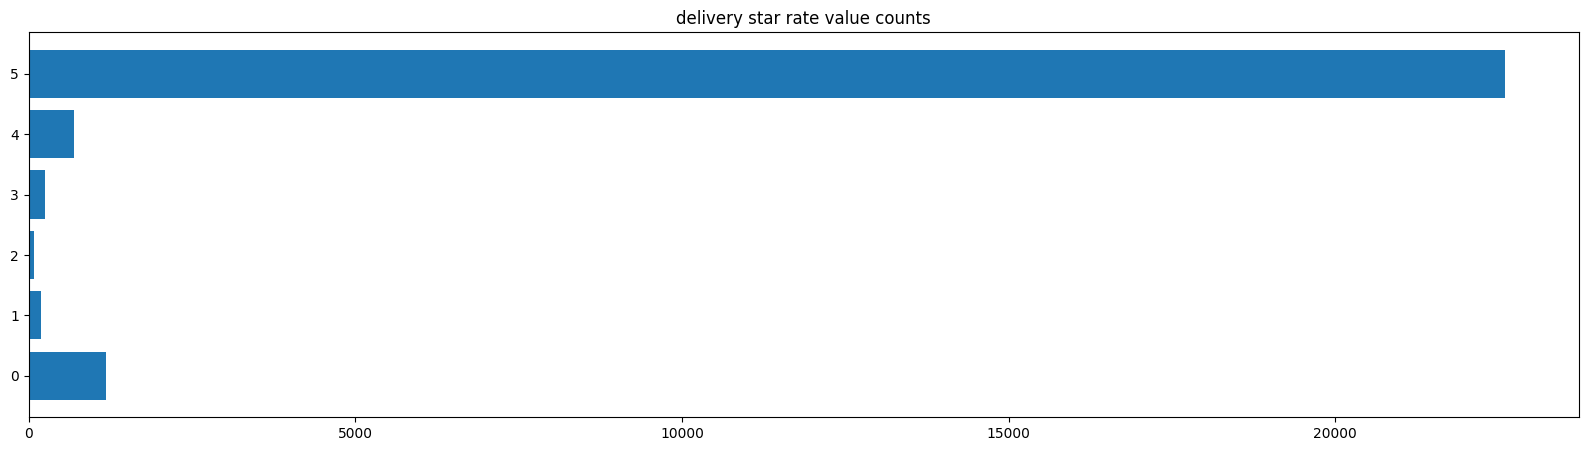

In [37]:
plt.figure(figsize=(20, 5))
plt.barh([5,4,3,2,1,0], delivery_rate_counts)
plt.title("delivery star rate value counts")
plt.show()

In [33]:
mask =  yogiyo_df["배달별점"] == 0.0
yogiyo_df.loc[mask]

,가게이름,고객리뷰,별점,맛별점,양별점,배달별점,사장댓글,메뉴
49,1988응답하라추억의옛날도시락-방이점,가성비 아주 만족 합니다.\n맛있게 잘먹었습니다.,5,5,5,0.0,즐거운 순간을 저희와 함께해주셔서 감사합니다💖\n\n믿고 찾아 주셔서 진심으로 감사...,삼겹정찬도시락
101,1988응답하라추억의옛날도시락-방이점,가성비 아주 만족 합니다.\n양많고 맛도 좋아요,5,5,5,0.0,이렇게 저희 매장 찾아주셔서 감사드립니다🙏\n\n맛있다는 말씀은 언제 들어도 설레는...,삼겹정찬도시락
191,워커스커피 로스터스,복숭아에이드 짱짱맛입니다,5,5,5,0.0,안녕하세요! 주문 감사드립니다 !저희 간판 메뉴 중 하나 입니다 ㅎㅎ 맛있게 드셨다...,[GANPAN] 구봉근에이드／막내 봉근이를 넣은 메뉴
209,워커스커피 로스터스,차에서 먹을려고 테이크아웃 했어요.\n맛있어요.,5,5,5,0.0,안녕하세요! 주문해주셔서 감사드립니다 따뜻할때 아메리카노와 함께 먹는 와플은 정말 ...,[GANPAN] 리에주와플
285,워커스커피 로스터스,또 주문했어요ㅋ\n여기 커피 최고에요ㅋ,5,5,5,0.0,칭찬해주시니 감사합니다!\n자주 찾아주세요! 항상 일정한 맛과 최고의 서비스로 보답...,"오렌지브레붸[SIGNATURE],블렌딩바닐라라떼"
...,...,...,...,...,...,...,...,...
24724,유쾌한꼬막&한끼끝판왕-광주직영점,양 푸짐하고 맛있어요,5,5,5,0.0,맛있게 드셨다니 감사합니다😊\n항상 푸짐한 양과 최고의 맛으로 \n보답 드리는 유쾌...,끝판왕양념밥
24729,유쾌한꼬막&한끼끝판왕-광주직영점,온갖 해산물 싫어하는 사람입니다. 냄새 1도 없고 맛있게 먹었습니다.,5,5,5,0.0,저희 음식에 만족해주셔서 너무 감사드립니다😊\n앞으로도 변함없는 맛으로 보답드리겠습...,끝판왕양념밥
24757,유쾌한꼬막&한끼끝판왕-광주직영점,음식은 맛있어요 그런데 깻잎이 상태가 별로네요 다음엔 신경써주세요,5,5,5,0.0,식사에 불편을 드려 죄송합니다🙏🏻😭\n말씀해주신 내용 참고해서 다음번엔 만족스러운 ...,"신선한육회비빔밥 ＋ 소고기미역국,벌교꼬막무침"
24813,놀부 부대찌개-광주우산점,육수 넉넉히 주셔서 감사합니다~^^,5,5,5,0.0,놀부를 이용해 주셔서 감사합니다.\n고객분들의 의견을 반영해 저희 매장에서는\n육수...,놀부부대 2인*


In [32]:
mask =  yogiyo_df["배달별점"] == 1.0
yogiyo_df.loc[mask]

,가게이름,고객리뷰,별점,맛별점,양별점,배달별점,사장댓글,메뉴
65,1988응답하라추억의옛날도시락-방이점,20분 이내 배달 알림 주시고는 한시간이 지나서야 받았습니다. 배달이 늦는 점에 대...,2,4,4,1.0,안녕하세요 1988응답하라추억의옛날도시락 입니다.\n\n남겨 주신 리뷰 잘 읽어보았...,"스팸옛날도시락＋미니냉면＋（서비스）콜라,제육옛날도시락＋김찌 정식＋（서비스）콜라"
85,1988응답하라추억의옛날도시락-방이점,맛이나 양은 무난해요\n그런데...\n배달예정시간이 무색하게 늦게도착ㅜㅜ\n차라리 ...,3,3,4,1.0,1988응답하라추억의옛날도시락을 선택해 주셔서 감사합니다. \n\n저희 매장에서는 ...,제육정찬도시락
93,1988응답하라추억의옛날도시락-방이점,예정시간보다 30분이 지나서야 도착하고 음식도 다 식어서 왔네요,3,3,4,1.0,1988응답하라추억의옛날도시락을 선택해 주셔서 감사합니다. \n\n저희 매장에서는 ...,"제육옛날도시락＋김찌 정식＋（서비스）콜라,엄마가 해주는 계란후라이,비빔장"
99,1988응답하라추억의옛날도시락-방이점,배달 늦게옴 \n전화주면 받으러나간다니깐 전화 안줌,2,3,3,1.0,저희 1988응답하라추억의옛날도시락을 찾아 주셔서 감사합니다. \n\n맛있게 드시는...,삼겹옛날도시락＋미니냉면＋（서비스）콜라
138,1988응답하라추억의옛날도시락-방이점,리뷰 이벤트 한다지만 너무 아닌 거 같아서 적습니다. 배달이 20분 넘게 안오길래 ...,1,1,1,1.0,안녕하세요 1988응답하라추억의옛날도시락 입니다.\n\n주신 리뷰 잘 읽었습니다. ...,[강추]우삼겹옛날도시락
...,...,...,...,...,...,...,...,...
24169,빕스얌딜리버리-광주광천점,"일회용수저, 포크가 필요하다고 체크했는데ㅠㅠ안챙겨주셨네요ㅠㅠ",3,3,2,1.0,안녕하세요 빕스 얌 딜리버리 광천점입니다 : )\n고객님께서 요청하신 사항 못챙겨드...,"（5%할인） 안심 스테이크 2인 세트,시그니처 바비큐 폭립,시즈널 스프"
24171,빕스얌딜리버리-광주광천점,음식은 맛있어요.배달은 스테이크 다 식어서 극혐입니다ㅡ.ㅡ;; 요기요익스프레스 하...,4,5,5,1.0,안녕하세요 빕스 얌 딜리버리 광천점입니다 : )\n먼저 만족스러운 식사를 제공해드리...,"블랙 페퍼 채끝 스테이크,시그니처 훈제 연어 샐러드"
24431,띵하오차이,"아니 숙박업소에서 배달을 시켰습니다\n탕수육,짬뽕밥,소주한병..\n그런데 수저를 시...",3,4,3,1.0,ld**님~\n정말정말 죄송합니다. \n식사하시는데 불편을 드려서 너무너무 죄송합니...,탕수육＋짬뽕밥＋음료
24475,띵하오차이,벨 안누르시고 그냥 음식만 두고가셔서 면이 떡됐어요ㅋ..,4,5,5,1.0,eo**님~\n헉!! 이런 ㅠ.ㅠ 죄송합니다.\n배달대행 업체에 다시한번 주의...,탕수육＋짬뽕＋음료


배달 별점이 0점인 경우는 고객이 불만족한 것이 아니라 평가를 안한 것으로 추측됨

별점 4점이하인 데이터들을 증강하고 학습을 시켜보고자함


In [ ]:
yogiyo_df["배달별점"] == 1.0

In [ ]:
yogiyo_df = yogiyo_df[["고객리뷰", "사장댓글"]]

In [ ]:
yogiyo_df["고객리뷰"] = yogiyo_df["고객리뷰"].str.replace("[^A-Za-z가-힣0-9 .,!?]" , " ",regex=True)
yogiyo_df["사장댓글"] = yogiyo_df["사장댓글"].str.replace("[^A-Za-z가-힣0-9 .,!?]" , " ",regex=True)

yogiyo_df

<ipython-input-10-ee080adb76aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yogiyo_df["고객리뷰"] = yogiyo_df["고객리뷰"].str.replace("[^A-Za-z가-힣0-9 .,!?]" , " ",regex=True)
<ipython-input-10-ee080adb76aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yogiyo_df["사장댓글"] = yogiyo_df["사장댓글"].str.replace("[^A-Za-z가-힣0-9 .,!?]" , " ",regex=True)


,고객리뷰,사장댓글
0,사진보다 실물이 백배 맛있어요 고기 양도 많아요 배달시간도 딱...,"이렇게 저희 매장 찾아주셔서 감사드립니다!! 맛 뿐만 아니라 양도, 서비스도 모두..."
1,리뷰가 늦었네요.. 맛있게 잘 먹었습니다. 또 시킬게요!!,좋은 리뷰 덕분에 기분이 행복해지는 것 같아요 고객님께서 맛있다고 말씀 주시니 ...
2,잘 먹었습니다. 다만 주문에 있던 펩시콜라는 받지 못했습니다.,소중한 식사 시간에 저희 매장을 찾아 주셔서 감사드립니다. 저희를 찾아 주신 만...
3,굿 말이 필요 없는 메뉴 였습니다,수 많은 매장들을 헤치고 와주셔서 감사합니다!! 저희 매장의 메뉴를 제대로 즐기신...
4,맛있어요 양도많구좋음,수 많은 매장들을 헤치고 와주셔서 감사합니다 메뉴 그 자체로 행복을 드리고 싶었...
...,...,...
18681,맛있게 잘 먹었어요,감사합니다!!! 다음에도 이용해주세용
18682,요청사항을 항상 잘 들어주셨는데 오늘은 못 모셨나봐요 그래도 잘 먹었습니다,죄송합니다 !! 다음에도 애용해주세용
18683,배달 빨라요 맛있게 잘 먹었습니당 !,감사합니다!!! 다음에도 이용해주세용
18684,잘 먹었어요,감사합니다!!! 다음에도 이용해주세용


In [ ]:
yogiyo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18686 entries, 0 to 18685
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   고객리뷰    18686 non-null  object
 1   사장댓글    18686 non-null  object
dtypes: object(2)
memory usage: 292.1+ KB


In [ ]:
yogiyo_df

,고객리뷰,사장댓글
0,사진보다 실물이 백배 맛있어요 고기 양도 많아요 배달시간도 딱...,"이렇게 저희 매장 찾아주셔서 감사드립니다!! 맛 뿐만 아니라 양도, 서비스도 모두..."
1,리뷰가 늦었네요.. 맛있게 잘 먹었습니다. 또 시킬게요!!,좋은 리뷰 덕분에 기분이 행복해지는 것 같아요 고객님께서 맛있다고 말씀 주시니 ...
2,잘 먹었습니다. 다만 주문에 있던 펩시콜라는 받지 못했습니다.,소중한 식사 시간에 저희 매장을 찾아 주셔서 감사드립니다. 저희를 찾아 주신 만...
3,굿 말이 필요 없는 메뉴 였습니다,수 많은 매장들을 헤치고 와주셔서 감사합니다!! 저희 매장의 메뉴를 제대로 즐기신...
4,맛있어요 양도많구좋음,수 많은 매장들을 헤치고 와주셔서 감사합니다 메뉴 그 자체로 행복을 드리고 싶었...
...,...,...
18681,맛있게 잘 먹었어요,감사합니다!!! 다음에도 이용해주세용
18682,요청사항을 항상 잘 들어주셨는데 오늘은 못 모셨나봐요 그래도 잘 먹었습니다,죄송합니다 !! 다음에도 애용해주세용
18683,배달 빨라요 맛있게 잘 먹었습니당 !,감사합니다!!! 다음에도 이용해주세용
18684,잘 먹었어요,감사합니다!!! 다음에도 이용해주세용


가게 이름 제거 , ** 님 고객님으로 수정

In [ ]:
ygy_store_lst = ["1988응답하라추억의옛날도시락-방이점", "워커스커피 로스터스", "떡깨비-가락점", "당치땡-헬리오시티점", "우시장국밥-석촌점",  "고돼지-송파점",  "마라의신마라탕&마라샹궈",  "춘리마라탕-송파점",  "손수경의육회담은연어-가락점",  "무국적식탁-송파점",  "청년치킨-삼전점",  "송파만다린",  "배달의쌀국수-송파점",  "닭강점-헬리오시티점",  "토핑폭탄김치찜&김치찌개-송파점",  "조형훈족발보쌈",  "여왕의브런치",  "모어댄버터",  "플러스82-송파점",  "더티베지",  "잭아저씨족발보쌈-본점",  "육회&연어-미아본점",  "갈비민족-본점",  "구구족-성신여대역점",  "피자보이시나-대학로점",  "왕빈자삼파전-미아본점",  "행복한찜닭-성북점",  "스시사소우",  "저팔계&중국&마라탕&덮밥&요리&전문점",  "명작파스타-성북점",  "올데이파스타-동대문구점",  "대한냉면-성북점",  "인생제육",  "고기듬뿍미트박스-성북점",  "피자스웨그-성북점",  "청춘식당묵은지김치찜",  "삽교원조두리곱창",  "뜸들이다-북서울꿈의숲점",  "더팔당매운오징어&닭발 김치찜",  "우리집반찬도시락-혜화막내딸지점",  "수피자",  "마라쿡",  "김포불닭발",  "헬로팬닭갈비&마약볶음밥",  "대찌 대파생고기김치찌개&정육왕국물두루치기",  "구래상회",  "승도리네곱도리탕",  "자성당",  "수락",  "나인곱창",  "어시장",  "돈까스회관",  "호랑이초밥",  "땡초곱창막창",  "피자이탈리",  "텐텐마라탕",  "과일에반하다",  "삼다수",  "병천토속순대",  "최고남제육명가",  "짱닭치킨",  "걸작떡볶이",  "직화삼겹직구삼",  "짜글이가돼었소",  "부대찌개자신있는집",  "토핑폭탄김치찜&김치찌개-부천점",  "1989마라탕-부천점",  "미친피자-부평점",  "천년닭강정-부천부평점",  "수상한삼겹살-부천점",  "수제죽전문점-본가진죽-본점",  "오늘은 분식",  "이끌림마라탕",  "탐나는피자-부평점",  "고기혁명-부천점",  "라화방마라탕-신중동점",  "전금례닭볶음탕-부천점",  "큰아들백순대",  "공주닭발-부천시청점",  "신자매김치찜&김치찌개",  "짱닭치킨-도촌점",  "이태리면가게-야탑점",  "폴트버거-판교점",  "랜돌프뉴욕페페로니-야탑점",  "홍싸롱-수제돈까스&파스타",  "쇼부덮밥",  "카산도-정자본점",  "부성초밥-미금본점",  "닭장수섭삼계탕&전기구이통닭",  "깨돌이김밥-미금점",  "울진죽변항",  "GTS버거-분당정자점",  "코브라독스-분당미금역점",  "마라하오-죽전점",  "땅끝수산",  "초밥대통령-용인수지점",  "올데이케밥&샐러드",  "야키토리 카마쿠라",  "비오키친-서현본점",  "부산오빠1인국밥-분당점",  "알촌",  "밈피자",  "고씨네카레",  "홍스족발",  "뜸들이다",  "감성커피",  "짚신스시",  "떡형",  "39도시락",  "피제이피자",  "황궁쟁반짜장",  "OK반점",  "모모타코야키&카페",  "꼬알라파이",  "진지덮밥",  "피자프라텔로",  "한식세끼1인김치찜&김치찌개",  "윤희횟집",  "시민보쌈족발&감자탕",  "카페봄봄",  "킹프레소빅와플",  "최가네한쌈",  "창타이누들",  "보돌미역",  "홍대개미"  ]
len(ygy_store_lst)

125

In [ ]:
ygy_store_lst = [re.split("[-,& ]", i ) for i in ygy_store_lst]

In [ ]:
ygy_store_lst = sum(ygy_store_lst, [])

In [ ]:

del_reply = []
for reply in yogiyo_df["사장댓글"]:
    reply_words = reply.split()
    new_reply_words = []
    for reply_word in reply_words:
        if not any(store in reply_word for store in ygy_store_lst): new_reply_words.append(reply_word)

    new_reply = ' '.join(new_reply_words)
    del_reply.append(new_reply)


In [ ]:
yogiyo_df["사장댓글"] = del_reply
yogiyo_df

<ipython-input-18-a596bb12a52c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yogiyo_df["사장댓글"] = del_reply


,고객리뷰,사장댓글
0,사진보다 실물이 백배 맛있어요 고기 양도 많아요 배달시간도 딱...,"이렇게 저희 매장 찾아주셔서 감사드립니다!! 맛 뿐만 아니라 양도, 서비스도 모두 ..."
1,리뷰가 늦었네요.. 맛있게 잘 먹었습니다. 또 시킬게요!!,좋은 리뷰 덕분에 기분이 행복해지는 것 같아요 고객님께서 맛있다고 말씀 주시니 피로...
2,잘 먹었습니다. 다만 주문에 있던 펩시콜라는 받지 못했습니다.,소중한 식사 시간에 저희 매장을 찾아 주셔서 감사드립니다. 저희를 찾아 주신 만큼 ...
3,굿 말이 필요 없는 메뉴 였습니다,수 많은 매장들을 헤치고 와주셔서 감사합니다!! 저희 매장의 메뉴를 제대로 즐기신 ...
4,맛있어요 양도많구좋음,수 많은 매장들을 헤치고 와주셔서 감사합니다 메뉴 그 자체로 행복을 드리고 싶었는데...
...,...,...
18681,맛있게 잘 먹었어요,감사합니다!!! 다음에도 이용해주세용
18682,요청사항을 항상 잘 들어주셨는데 오늘은 못 모셨나봐요 그래도 잘 먹었습니다,죄송합니다 !! 다음에도 애용해주세용
18683,배달 빨라요 맛있게 잘 먹었습니당 !,감사합니다!!! 다음에도 이용해주세용
18684,잘 먹었어요,감사합니다!!! 다음에도 이용해주세용


In [ ]:
yogiyo_df["사장댓글"] = yogiyo_df["사장댓글"].str.replace(r'\w+\s*님', '고객님', regex=True)
yogiyo_df

<ipython-input-19-a28c6ff86aaf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yogiyo_df["사장댓글"] = yogiyo_df["사장댓글"].str.replace(r'\w+\s*님', '고객님', regex=True)


,고객리뷰,사장댓글
0,사진보다 실물이 백배 맛있어요 고기 양도 많아요 배달시간도 딱...,"이렇게 저희 매장 찾아주셔서 감사드립니다!! 맛 뿐만 아니라 양도, 서비스도 모두 ..."
1,리뷰가 늦었네요.. 맛있게 잘 먹었습니다. 또 시킬게요!!,좋은 리뷰 덕분에 기분이 행복해지는 것 같아요 고객님께서 맛있다고 말씀 주시니 피로...
2,잘 먹었습니다. 다만 주문에 있던 펩시콜라는 받지 못했습니다.,소중한 식사 시간에 저희 매장을 찾아 주셔서 감사드립니다. 저희를 찾아 주신 만큼 ...
3,굿 말이 필요 없는 메뉴 였습니다,수 많은 매장들을 헤치고 와주셔서 감사합니다!! 저희 매장의 메뉴를 제대로 즐기신 ...
4,맛있어요 양도많구좋음,수 많은 매장들을 헤치고 와주셔서 감사합니다 메뉴 그 자체로 행복을 드리고 싶었는데...
...,...,...
18681,맛있게 잘 먹었어요,감사합니다!!! 다음에도 이용해주세용
18682,요청사항을 항상 잘 들어주셨는데 오늘은 못 모셨나봐요 그래도 잘 먹었습니다,죄송합니다 !! 다음에도 애용해주세용
18683,배달 빨라요 맛있게 잘 먹었습니당 !,감사합니다!!! 다음에도 이용해주세용
18684,잘 먹었어요,감사합니다!!! 다음에도 이용해주세용


In [ ]:
yogiyo_df["고객리뷰"] = [' '.join(i.split()) for i in yogiyo_df["고객리뷰"]]
yogiyo_df["사장댓글"] = [' '.join(i.split()) for i in yogiyo_df["사장댓글"]]

<ipython-input-20-5e998ffcb67d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yogiyo_df["고객리뷰"] = [' '.join(i.split()) for i in yogiyo_df["고객리뷰"]]
<ipython-input-20-5e998ffcb67d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yogiyo_df["사장댓글"] = [' '.join(i.split()) for i in yogiyo_df["사장댓글"]]


In [ ]:
yogiyo_df

,고객리뷰,사장댓글
0,사진보다 실물이 백배 맛있어요 고기 양도 많아요 배달시간도 딱 맞춰서 보내주셨어요,"이렇게 저희 매장 찾아주셔서 감사드립니다!! 맛 뿐만 아니라 양도, 서비스도 모두 ..."
1,리뷰가 늦었네요.. 맛있게 잘 먹었습니다. 또 시킬게요!!,좋은 리뷰 덕분에 기분이 행복해지는 것 같아요 고객님께서 맛있다고 말씀 주시니 피로...
2,잘 먹었습니다. 다만 주문에 있던 펩시콜라는 받지 못했습니다.,소중한 식사 시간에 저희 매장을 찾아 주셔서 감사드립니다. 저희를 찾아 주신 만큼 ...
3,굿 말이 필요 없는 메뉴 였습니다,수 많은 매장들을 헤치고 와주셔서 감사합니다!! 저희 매장의 메뉴를 제대로 즐기신 ...
4,맛있어요 양도많구좋음,수 많은 매장들을 헤치고 와주셔서 감사합니다 메뉴 그 자체로 행복을 드리고 싶었는데...
...,...,...
18681,맛있게 잘 먹었어요,감사합니다!!! 다음에도 이용해주세용
18682,요청사항을 항상 잘 들어주셨는데 오늘은 못 모셨나봐요 그래도 잘 먹었습니다,죄송합니다 !! 다음에도 애용해주세용
18683,배달 빨라요 맛있게 잘 먹었습니당 !,감사합니다!!! 다음에도 이용해주세용
18684,잘 먹었어요,감사합니다!!! 다음에도 이용해주세용


In [ ]:
# from kiwipiepy import Kiwi
# kiwi = Kiwi()

In [ ]:
# review = kiwi.tokenize(df["content"])
# reply = kiwi.tokenize(df["replyContent"])

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
model_name = "skt/kogpt2-base-v2"

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          bos_token='</s>',
                                          eos_token='</s>',
                                          unk_token='<unk>',
                                          pad_token='<pad>',
                                          mask_token='<mask>',
                                          max_len=2048)

In [ ]:
class ReplyDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.question = df["고객리뷰"].tolist()
        self.answer = df["사장댓글"].tolist()

    def __len__(self):
        return len(self.question)

    def __getitem__(self,idx):
        return "<q>" + self.question[idx] + "</s><a>" + self.answer[idx] + "</s>"

In [ ]:
def collate_fn(batch):
    x = tokenizer(batch, return_tensors="pt",padding=True)
    return {"x":x}

In [ ]:
dt = ReplyDataset(yogiyo_df)
dl = torch.utils.data.DataLoader(dt, batch_size=2, collate_fn=collate_fn)
batch = next(iter(dl))
batch

{'x': {'input_ids': tensor([[ 9724,   455,   405, 27013,  9518,  9137,  9984,  9358,  7609, 11355,
          49067,  8084, 22311, 15729, 12268,  8084, 28005, 10785,  7235, 16317,
          22353,  7788, 11219,  8236,  7816,  8006,  8084,     1,  9724,   439,
          28886, 10431,  9265,  8806, 13669, 10345,  8236,  7810,  7788, 15940,
           7281,  7483,  7172,  7182,   376,   376, 11355, 11178,  9554,  9164,
          10897, 10997,  7235,  9432, 41014, 40492, 21291, 11611, 30782,  9019,
          16913,  7182,  9548, 18401,  9136,  9723,  7071,  7788, 12298, 19495,
          13489, 35359,  9207,  9716, 10805, 26616, 16913,  7182, 12086, 11342,
          42226,  6958,  7888,  9075, 10070,  7235, 29080, 12557, 11219,  7888,
           6962, 13158,  6872, 16913,  7182,     1,     3,     3],
         [ 9724,   455,   405,  7478,  7685,  6824, 13289,  8017,  7098,  8084,
           9705, 11355, 18479,  9443,  9784,  8017, 16691,  9108,  9039,  8514,
           6866,  8084,   376,   3

In [ ]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0
    model.train()
    for batch in tqdm(dataloader):
        x = batch["x"].to(device)
        pred = model(**x).logits
        n_class = pred.shape[-1]
        pred = pred[:,:-1]
        pred = pred.reshape(-1,n_class)

        tgt = x["input_ids"][:,1:]
        tgt = tgt.flatten()

        mask = tgt != 3
        tgt = tgt[mask]
        pred = pred[mask]
        loss = loss_fn(pred,tgt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

In [ ]:
batch_size = 2
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

In [ ]:
reset_seeds(SEED)

model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-5)

train_dt = ReplyDataset(yogiyo_df)
train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers = 8 )

for _ in range(epochs):
    train_loss = train_loop(train_dl, model, loss_fn, optimizer, device)
    print(train_loss)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/9343 [00:00<?, ?it/s]

1.647545783687114


  0%|          | 0/9343 [00:00<?, ?it/s]

1.2795127534436028


  0%|          | 0/9343 [00:00<?, ?it/s]

1.1229850400239627


  0%|          | 0/9343 [00:00<?, ?it/s]

1.004023367465882


  0%|          | 0/9343 [00:00<?, ?it/s]

0.8988729974016328


  0%|          | 0/9343 [00:00<?, ?it/s]

0.8030054445384364


  0%|          | 0/9343 [00:00<?, ?it/s]

0.7176299852388939


  0%|          | 0/9343 [00:00<?, ?it/s]

0.6401425850116427


  0%|          | 0/9343 [00:00<?, ?it/s]

0.5727710753597935


  0%|          | 0/9343 [00:00<?, ?it/s]

0.511990322652388


In [ ]:
model.save_pretrained(f"{DATA_PATH}kogpt2_chat")